In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import jax.numpy as jnp 
from jax import random

# Build a diffusion solver

In this series of notebooks we use logistic regression as the example. However the usage is exactly the same for other models.

Here we go to the lowest level of abstraction in `SGMCMCJax`: the solver for the diffusion.

In [2]:
# import model and create dataset
from models.logistic_regression import gen_data, loglikelihood, logprior

key = random.PRNGKey(42)
dim = 10
Ndata = 100000 

theta_true, X, y_data = gen_data(key, dim, Ndata)

data = (X, y_data)

generating data, with N=100000 and dim=10


Here we import the solver for the Langevin diffusion for SGLD. We also import the function that builds the gradient of the log-posterior.

The usage of the diffusion function is very similar to JAX [optimizer's](https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html) module. Calling `sgld(1e-5)` return 3 functions:

- `init_fn`: this takes in the initial parameter and returns a `state` object
- `update`: this takes in the iteration number, random key, gradient, and state. It returns the updated state
- `get_params`: this takes in a `state` object and returns the parameter


Note that here we must calculate the gradient at each iteration ourselves. This is useful if the data doesn't fit in memory so must be regularly loaded into memory. It is also useful if we want to implement our own gradient estimator that isn't included in the package.

In this example we simply use the entire dataset with a Langevin diffusion. As a result this sampler is the Unadjusted Langevin Algorithm.

In [3]:
from sgmcmcjax.diffusions import sgld
from sgmcmcjax.util import build_grad_log_post

In [4]:
init_fn, update, get_params = sgld(1e-5)
grad_log_post = build_grad_log_post(loglikelihood, logprior, data)

Nsamples = 1000
state = init_fn(theta_true)
samples = []

for i in tqdm(range(Nsamples)):
    key, subkey = random.split(key)
    mygrad = grad_log_post(get_params(state), *data) # use all the data.
    state = update(0, subkey, mygrad, state)
    samples.append(get_params(state))
    
samples = np.array(samples)

  0%|          | 0/1000 [00:00<?, ?it/s]

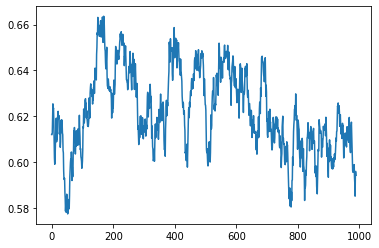

In [5]:
plt.plot(samples[10:,1])